# Language Detection
#### Dataset: <a href='https://www.kaggle.com/datasets/basilb2s/language-detection'>Click Here</a>
# Importing necessary libraries

In [ ]:
import polars
import seaborn
import matplotlib.pyplot as mplot
from itertools import islice
import os

import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import tensorflow
from transformers import TFAutoModelForSequenceClassification, AutoTokenizer
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import datetime

import numpy
from sklearn.metrics import classification_report

In [2]:
dataset = polars.read_csv('Language Detection.csv')
dataset.head()

Text,Language
str,str
""" Nature, in the broadest sense…","""English"""
"""""Nature"" can refer to the phen…","""English"""
"""The study of nature is a large…","""English"""
"""Although humans are part of na…","""English"""
"""[1] The word nature is borrowe…","""English"""


In [3]:
dataset.shape

(10337, 2)

# Checking for missing values

In [4]:
dataset.null_count()

Text,Language
u32,u32
0,0


# Visualizing the language distribution

In [5]:
dataset['Language'].value_counts()

Language,count
str,u32
"""Kannada""",369
"""German""",470
"""Tamil""",469
"""Hindi""",63
"""Turkish""",474
…,…
"""Arabic""",536
"""Russian""",692
"""Spanish""",819


<Axes: xlabel='Language', ylabel='count'>

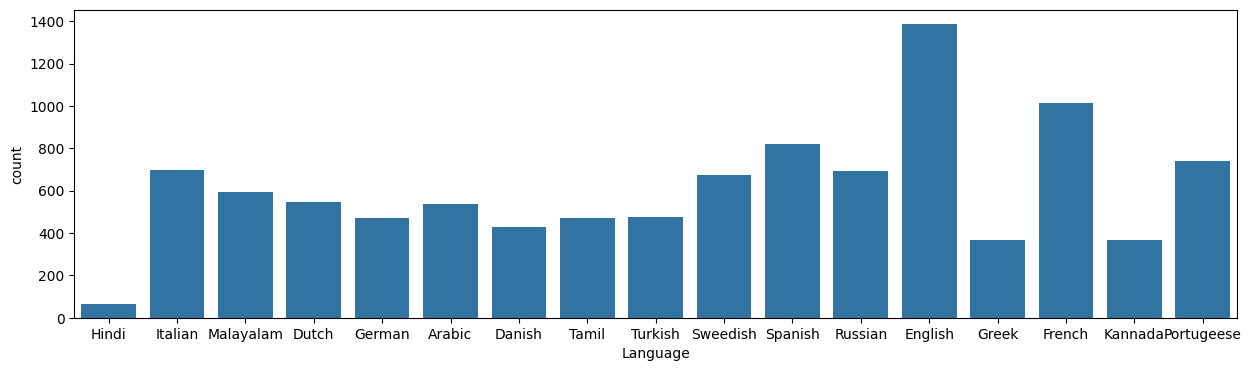

In [6]:
mplot.figure(figsize=(15, 4))
seaborn.barplot(
    data=dataset['Language'].value_counts(),
    x='Language',
    y='count'
)

In [7]:
max(dataset['Language'].value_counts()['count'])

1385

In [8]:
max_coupus_len = max(dataset['Language'].value_counts()['count'])
lang_samples = {}

for lang in dataset['Language'].value_counts()['Language']:
    print(f'Necessary samples for {lang}: {max_coupus_len - dataset['Language'].value_counts().filter(polars.col('Language') == lang)['count'][0]}')
    lang_samples.update({lang: max_coupus_len - dataset['Language'].value_counts().filter(polars.col('Language') == lang)['count'][0]})

Necessary samples for Portugeese: 646
Necessary samples for Spanish: 566
Necessary samples for French: 371
Necessary samples for Kannada: 1016
Necessary samples for Tamil: 916
Necessary samples for Russian: 693
Necessary samples for Arabic: 849
Necessary samples for Malayalam: 791
Necessary samples for Sweedish: 709
Necessary samples for Italian: 687
Necessary samples for Greek: 1020
Necessary samples for English: 0
Necessary samples for Hindi: 1322
Necessary samples for German: 915
Necessary samples for Dutch: 839
Necessary samples for Turkish: 911
Necessary samples for Danish: 957


In [9]:
lang_samples

{'Portugeese': 646,
 'Spanish': 566,
 'French': 371,
 'Kannada': 1016,
 'Tamil': 916,
 'Russian': 693,
 'Arabic': 849,
 'Malayalam': 791,
 'Sweedish': 709,
 'Italian': 687,
 'Greek': 1020,
 'English': 0,
 'Hindi': 1322,
 'German': 915,
 'Dutch': 839,
 'Turkish': 911,
 'Danish': 957}

#### Addressing the class imbalance issue:
<ul>
    <li>Need to add these many samples per language category by collecting data from external sources</li>
    <li>These data have been collected from: <a href='https://tatoeba.org/en/downloads'>Tatoeba Website</a></li>
    <li>From each file the above mentioned samples must be added on to the final dataset</li>
</ul>

# Performing sample addition

In [10]:
temp_df = {}
sentences = []
languages = []

for lang, samples in lang_samples.items():
    if lang != 'English':
        with open(file='extra datasets/'+lang+'_sentences.tsv', mode='r', encoding='UTF-8') as fp:
            lines = islice(fp, samples)
        
            for line in lines:
                sentence = line.split('\t')[-1]
                sentences.append(' '.join(sentence))
                languages.append(lang)


temp_df.update({'Text': sentences, 'Language': languages})
temp_df = polars.DataFrame(data=temp_df)
temp_df.head()

Text,Language
str,str
"""U m a m e n i n a c h o r …","""Portugeese"""
"""V a m o s t e n t a r a l …","""Portugeese"""
"""P r e c i s o i r d o r m …","""Portugeese"""
"""O s i n a l ' & ' s i g …","""Portugeese"""
"""A m a r c a ' & ' s i g …","""Portugeese"""


In [11]:
temp_df.shape

(12088, 2)

In [14]:
dataset = dataset.vstack(temp_df)
del temp_df, languages, sentences

<Axes: xlabel='Language', ylabel='count'>

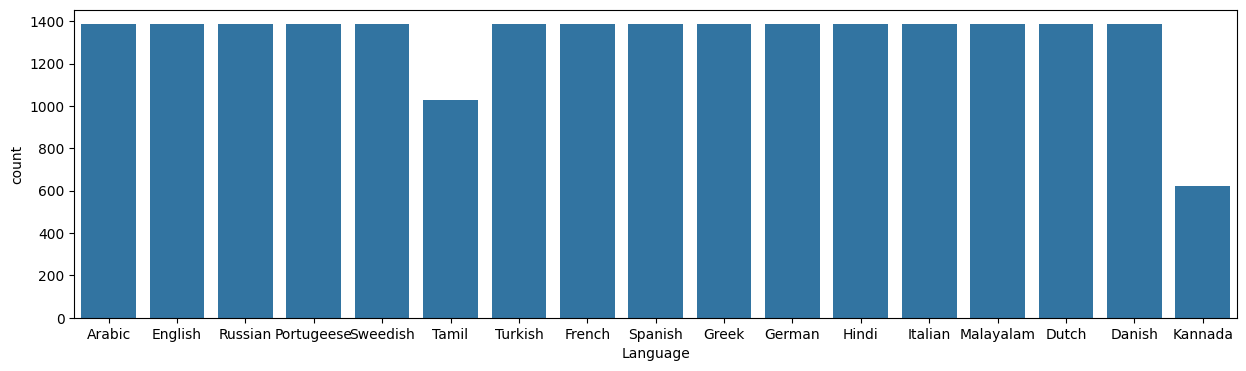

In [15]:
mplot.figure(figsize=(15, 4))
seaborn.barplot(
    data=dataset['Language'].value_counts(),
    x='Language',
    y='count'
)

#### Addressing the class imbalance issue:
<ul>
    <li>Tamil and Kannada still have imabalance</li>
    <li>The extra data is collected from: <a href='https://huggingface.co/datasets/cfilt/IITB-IndicMonoDoc'>HuggingFace - IIITB-IndicMonoDoc repository</a></li>
</ul>

In [16]:
dataset.shape

(22425, 2)

In [2]:
def add_languages(filename, samples):
    lang = []

    with open(file=filename, mode='r', encoding='UTF-8') as fp:
        lines = islice(fp, samples)

        for line in lines:
            if line.strip() not in ['<DOC_START>', '<DOC_END>']:
                line = line.split('\u0964')
                
                if len(line) > 1:
                    for l in line:
                        if l != '\n':
                            lang.append(l)
                else:
                    if line[0] != '\n':
                        lang.append(line[0])

    return lang

In [28]:
temp_df = {}

for file in os.listdir('extra datasets'):
    if file.endswith('.txt'):
        
        samples = 2000
        while True:
            lang = add_languages(filename='extra datasets/' + file, samples=samples)
            
            if len(lang) == 1385:
                temp_df.update({file[:-4:]: lang})
                break
            elif len(lang) > 1385:
                temp_df.update({file[:-4:]: lang[:1385:]})
                break
            else:
                samples += 1000
                continue


In [15]:
dataset.filter(polars.col('Language').is_in(['Tamil', 'Kannada']))['Language'].value_counts()

Language,count
str,u32
"""Tamil""",1029
"""Kannada""",621


In [30]:
temp_df.update({'Tamil': temp_df['Tamil'][:1385-1029:]})
temp_df.update({'Kannada': temp_df['Kannada'][:1385-621:]})

In [31]:
temp_df = {'Text': temp_df.values(), 'Language': [key for key in temp_df.keys()]}
temp_df = polars.DataFrame(data=temp_df)
temp_df.head()

Text,Language
list[str],str
"[""বাংলাদেশ-ভুটানের মধ্যকার কূটনৈতিক সম্পর্কের ৫০ বছর উপলক্ষে এই দিনেই সই হলো অগ্রাধিকারমূলক বাণিজ্য চুক্তি (পিটিএ)"", "" এ চুক্তির আওতায় ভুটানের বাজারে তৈরি পোশাক, প্রক্রিয়াজাত খাদ্যসামগ্রী, কৃষিজাত পণ্য, প্রসাধনী সামগ্রী, শুঁটকি মাছ, কৃষিজাত পণ্য, চা, প্লাইউড, লাইট ইঞ্জিনিয়ারিং পণ্যসহ মোট একশটি পণ্যের শুল্কমুক্ত সুবিধা পেলো বাংলাদেশ"", … ""মঙ্গলবার এক বিবৃতিতে এ তথ্য নিশ্চিত করেন মার্কিন পররাষ্ট্রমন্ত্রী মাইক পম্পেও""]","""Bengali"""
"[""ಅಡಿಗರು ಮತ್ತು ರಾಯರು ಚಾಪೆ ಹಾಸಿ ಸ್ವಲ್ಪ ಹೊತ್ತು ಮಲಗಿ ಕಾಫಿ ಕುಡಿದು ಹೊರಟುಹೋದಿದ್ದರು. ಜಾತ್ರೆ ದಿನ ಜಗನ್ನಾಥನ ಮನೆಗೆ ಬರಬಹುದಾದ ನೂರಾರು ಯಾತ್ರಿಕರಿಗಾಗಿ ಅಡಿಗರು ತಂದ ಒಣಗಿದ ಬಾಳೆಲೆ ಕಟ್ಟುಗಳನ್ನೂ ದೊನ್ನೆಗಳನ್ನೂ ಚಿಕ್ಕಿ ಕೊಂಡಿದ್ದರು. ಆದರೆ ತಮ್ಮಲ್ಲಿಗೆ ಯಾರಾದರೂ ಇನ್ನು ಮುಂದೆ ಊಟಕ್ಕೆ ಬರುವುದುಂಟೆ ಎಂದು ದುಃಖಿಸುತ್ತ ಜಗಣ್ಣನಿಗೆ ಬುದ್ಧಿ ಹೇಳುವಂತೆ ಅಡಿಗರನ್ನು ಬೇಡಿದ್ದಳು. ಕಾಲಾಯ ತಸ್ಮೈ ನಮಃ ಎಂದು ಸಮಾಧಾನ ಹೇಳಿದ ಅಡಿಗರಿಗೆ ‘ನಿಮ್ಮ ಮಕ್ಕಳಿಗೆ ಕೊಡಿ’ ಎಂದು ಬಾಳೆಲ್ಲಿ ಜಿಲೇಬಿ ಕಟ್ಟಿಕೊಟ್ಟರು. "", ""ಇಬ್ಬರೂ ಹೋದ ಮೇಲೆ ಜಗನ್ನಾಥ ಆತುರದಿಂದ ಹೊಲೆಯರ ಯುವಕರಿಗಾಗಿ ಕಾದ. ಚಾವಡಿಯಲ್ಲಿ ಕುರ್ಚಿಯ ಮೇಲೆ ಕೂತು ಇವತ್ತು ಬಂದವರು ತನ್ನನ್ನು ಮುಟ್ಟುವರೋ ನೋಡಬೇಕು ಅಂದುಕೊಂಡ. ಈ ತನಕ ಆ ಬಗ್ಗೆ ತಾನು ವಿಚಾರ ಮಾಡಲೇ ಇಲ್ಲವಲ್ಲ ಎನ್ನಿಸಿತು. ಮರಳಿನಲ್ಲಿ ಅಕ್ಷರ ಕಲಿಯುತ್ತಿದ್ದವರಿಗೆ ತಾನು ತಂದ ಹೊಸ ಸ್ಲೇಟು ಬಳಪಗಳನ್ನು ಕೊಡಲೆಂದು ಪಕ್ಕದಲ್ಲಿಟ್ಟುಕೊಂಡಿದ್ದ. ಅವರು ಕಲಿಯಲೇಬೇಕಾದ ಅತ್ಯಗತ್ಯ ಅಕ್ಷರಗಳು ಯಾವುವು, ಓದಲು ಕಲಿತ ಮೇಲೆ ಅವರಿಗೆ ಕೊಡಲು ಯೋಗ್ಯವಾದ ಪುಸ್ತಕಗಳು ಎಷ್ಟಿವೆ? ‘ಚೋಮನ ದುಡಿ’ ಓದಿಸಬೇಕು. ಮತ್ತೆ ತಾನೇ ಸರಳವಾಗಿ ಬರೆಯಬೇಕು ಬಸವಣ್ಣನ ಬಗ್ಗೆ, ಈಸೂರಿನ ಬಗ್ಗೆ, ಫ್ರೆಂಚ್ ರಷ್ಯನ್ ಕ್ರಾಂತಿಗಳ ಬಗ್ಗೆ, ಚೀನಾದ ಸಾಂಸ್ಕೃತಿಕ ಕ್ರಾಂತಿಯ ಬಗ್ಗೆ. ಕೆಲವು ಪುಟಗಳನ್ನು ಆಗಲೇ ಬರೆದಿದ್ದ. ಅವುಗಳನ್ನು ನಾಳೆ ಓದುವುದೆಂದುಕೊಂಡ. ಅವರ ಜೊತೆ ಏನನ್ನಾದರೂ ಮಾತಾಡಲು ಮುಜುಗರಪಡಬಾರದು. ಅವರಿಗೆ ನಿಜವಾಗುವಷ್ಟು ಮಾತ್ರ ನಿಜ ಎನ್ನುವ ಕಠಿಣ ವ್ರತಿಯಾಗಬೇಕು. ತನಗೆ ನಿಜವಾದದ್ದನ್ನೆಲ್ಲ ಅವರಿಗೂ ನಿಜ ಮಾಡುತ್ತ ಹೋಗಬೇಕು. ತನ್ನನ್ನು ಅವರು ತಾವಾಗಿಯೇ ಮುಟ್ಟುವಷ್ಟು ಮುಂದುವರೆದರೆ ಆ ಘಳಿಗೆಯಿಂದ ಉಳಿದದ್ದೆಲ್ಲ ಕ್ರಮೇಣ ನಿಜವಾಗುತ್ತ ಹೋಗುತ್ತದೆ ಮಂಜುನಾಥ ಹಿಂದೆ ಸರಿಯುತ್ತ ಹೋಗುತ್ತಾನೆ. ಅರಳಲು ಪ್ರಾರಂಭವಾಗುತ್ತದೆ. ಆತುರದಿಂದ ಕಾದ. "", … ""೧೯೪೭ ರ ಆಗಸ್ಟ್‌ ೨೯ ರಂದು ಭಾರತದ ರಾಜ್ಯಾಂಗ ಸಿದ್ಧಗೊಳಿಸಲು ಒಂದು ಸಮಿತಿ ರಚಿತವಾಯಿತು. ಅಧ್ಯಕ್ಷರಾಗಿ ಅಂಬೇಡಕರ್ ಆಯ್ಕೆಯಾದರು. ಸಮಿತಿಯ ಒಬ್ಬ ಸದಸ್ಯರಾಗಿದ್ದ ಶ್ರೀ ಟಿ.ಟಿ. ಕೃಷ್ಣಮಾಚಾರಿಯವರೇ ಹೀಗೆ ಹೇಳಿದ್ದಾರೆ: ""]","""Kannada"""
"[""``இந்தத் திட்டத்தில் சேர குறைந்தபட்சம் 1 கிராம் தங்கம் அளவுக்காவது முதலீடு செய்திருக்க வேண்டும். திட்டத்துக்கான கால அளவானது எட்டு வருடங்கள் ஆகும்.” "", ""ரிசர்வ் வங்கியின் சாவ்ரன் கோல்ட் பாண்ட் (Sovereign Gold Bond) திட்டத்தில் சந்தா செலுத்துவதற்கான தேதிகள் அறிவிக்கப்பட்டுள்ளன. இந்தத் திட்டத்தில் ஜூலை 6 முதல் ஜூலை 10-ம் தேதி வரை சந்தா செலுத்த அவகாசம் அளிக்கப்பட்டுள்ளது. இந்தத் திட்டமானது நவம்பர் 2015-ல் தங்கத்தை அப்படியே வாங்குவதைக் குறைக்கும் நோக்கிலும், நிதி சேமிப்பை ஊக்கப்படுத்தவும் கொண்டு வரப்பட்டது. "", … ""ஜே.பி நகர் சுற்றுப்புறத்தில் உள்ள கட்டுமான தளத்தில் பணிகளை துவங்குவதற்கான அவர்களது திட்டம், கோவிட் 19யை முன்னிட்டு ஊரடங்கு அறிவித்ததால் பாதிக்கப்பட்டது. அவர்கள் கொரோனாவைப் பற்றி அறிந்திருக்கவில்லை இப்பொழுதும் அவர்களுக்கு எதுவும் தெரியாது யாரோ எங்களிடம் கவனமாக இருக்கும்படி கூறினர், ஆனால் எதைப் பற்றி கவனமாக இருக்க வேண்டும் என்று கூட எங்களுக்கு தெரியாது. எங்களுக்கு தெரிந்ததெல்லாம் எங்களுக்கு வேலை இல்லை என்பது தான் என்று ஏப்ரல் மாதத் துவக்கத்தில் நாங்கள் அவர்களை முதலில் சந்தித்தபோது அமோதா கூறினார். ""]","""Tamil"""


In [32]:
temp_df = temp_df.explode(columns='Text')
temp_df.head()

Text,Language
str,str
"""বাংলাদেশ-ভুটানের মধ্যকার কূটনৈ…","""Bengali"""
""" এ চুক্তির আওতায় ভুটানের বাজার…","""Bengali"""
""" ২০২৪ সালে স্বল্পোন্নত দেশ থেক…","""Bengali"""
"""আজ রবিবার ফরেন সার্ভিস একাডেমি…","""Bengali"""
""" এর আগে দ্বিপাক্ষিক অগ্রাধিকার…","""Bengali"""


In [33]:
dataset.vstack(temp_df)['Language'].value_counts().filter(polars.col('count') > 1385)

Language,count
str,u32


In [34]:
dataset = dataset.vstack(temp_df)
del temp_df
dataset.shape

(24930, 2)

<Axes: xlabel='Language', ylabel='count'>

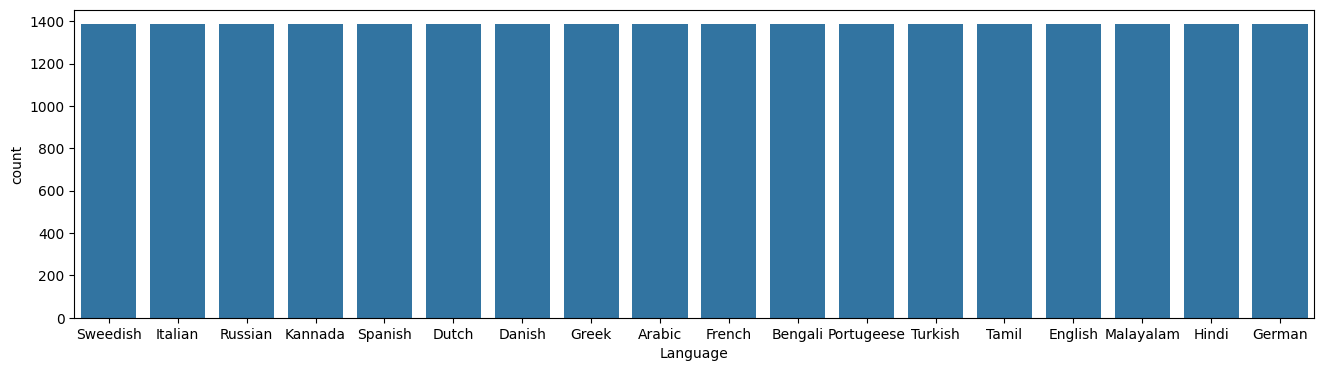

In [35]:
mplot.figure(figsize=(16, 4))
seaborn.barplot(
    data=dataset['Language'].value_counts(),
    x='Language',
    y='count'
)

##### The classes are balanced now, model will generalize well
#### Saving the file for futher use

In [37]:
dataset.write_csv('Final Language Dataset.csv')

# Preprocessing of Texts
## Checking for null

In [18]:
dataset.null_count()

Text,Language
u32,u32
0,0


## Removing emojis

In [19]:
emoji_pattern = re.compile(
    r"["
    r"\U0001F600-\U0001F64F"  # emoticons
    r"\U0001F300-\U0001F5FF"  # symbols & pictographs
    r"\U0001F680-\U0001F6FF"  # transport & map symbols
    r"\U0001F700-\U0001F77F"  # alchemical symbols
    r"\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
    r"\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
    r"\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
    r"\U0001FA00-\U0001FA6F"  # Chess symbols
    r"\U0001FA70-\U0001FAFF"  # Symbols and pictographs extended
    r"\U00002702-\U000027B0"  # Dingbats
    r"\U000024C2-\U0001F251"  # Enclosed characters
    r"\U0001F004-\U0001F0CF"  # Playing cards
    r"\U0001F170-\U0001F251"  # Miscellaneous symbols
    r"]", flags=re.UNICODE
)

In [20]:
# For emojis
def remove_emojis(text: str) -> str:
    return re.sub(emoji_pattern, '', text)

dataset = dataset.with_columns(
    polars.col('Text').
    map_elements(
        function=lambda r: remove_emojis(r),
        return_dtype=polars.String
    ).alias('Cleaned Text')
)

In [21]:
dataset.head()

Text,Language,Cleaned Text
str,str,str
""" Nature, in the broadest sense…","""English""",""" Nature, in the broadest sense…"
"""""Nature"" can refer to the phen…","""English""","""""Nature"" can refer to the phen…"
"""The study of nature is a large…","""English""","""The study of nature is a large…"
"""Although humans are part of na…","""English""","""Although humans are part of na…"
"""[1] The word nature is borrowe…","""English""","""[1] The word nature is borrowe…"


## Removing noisy data

In [22]:
substitutions = [
    (r'<.*?>', ''),                           # HTML tags
    (r'http\S+|www\S+|ftp\S+', ''),           # URLs
    (r'@\w+', ''),                            # Mentions (e.g., @username)
    (r'[^\w\s.,!?¿¡:؛،。’‘“”\'"—\-()]+', ''),  # Non-linguistic symbols (preserve punctuations)
    (r'\s+', ' '),                            # Normalize whitespace
]

In [23]:
def clean_text(text: str):
    if text is None:
        return ''
    for pattern, repl in substitutions:
        text = re.sub(pattern, repl, text)
    return text.strip()

dataset = dataset.with_columns(
    polars.col('Cleaned Text').
    map_elements(function=lambda n: clean_text(n), return_dtype=polars.Utf8).
    alias('Cleaned Text')
)

dataset.head()

Text,Language,Cleaned Text
str,str,str
""" Nature, in the broadest sense…","""English""","""Nature, in the broadest sense,…"
"""""Nature"" can refer to the phen…","""English""","""""Nature"" can refer to the phen…"
"""The study of nature is a large…","""English""","""The study of nature is a large…"
"""Although humans are part of na…","""English""","""Although humans are part of na…"
"""[1] The word nature is borrowe…","""English""","""1 The word nature is borrowed …"


In [48]:
dataset.write_csv('Cleaned Language Dataset.csv')

# Data Splitting

In [3]:
dataset = polars.read_csv('Cleaned Language Dataset.csv')

In [4]:
texts = dataset[:, -1:]
texts.head()

Cleaned Text
str
"""Nature, in the broadest sense,…"
"""""Nature"" can refer to the phen…"
"""The study of nature is a large…"
"""Although humans are part of na…"
"""1 The word nature is borrowed …"


In [5]:
lang = dataset[:, 1:2]
lang.head()

Language
str
"""English"""
"""English"""
"""English"""
"""English"""
"""English"""


In [6]:
xtrain, xtest, ytrain, ytest = train_test_split(texts, lang, test_size=0.2, random_state=42, stratify=dataset['Language'])
xval, xtest, yval, ytest = train_test_split(xtest, ytest, test_size=0.5, random_state=42, stratify=ytest['Language'])

## Checking for class distribution in train set

<Axes: xlabel='Language', ylabel='count'>

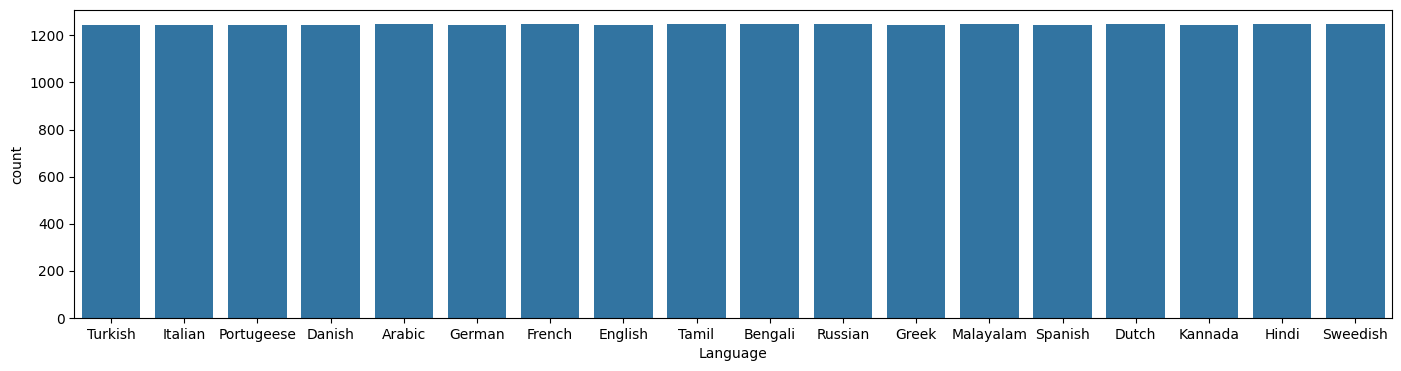

In [34]:
mplot.figure(figsize=(17, 4))
seaborn.barplot(data=ytrain['Language'].value_counts(), x='Language', y='count')

# Encoding target variable
##### Using Label Encoding for this purpose

In [9]:
LE=  LabelEncoder()
LE.fit(ytrain.to_numpy().reshape(-1,))

LabelEncoder()

In [10]:
ytrain_LE = LE.transform(ytrain.to_numpy().reshape(-1,))
ytrain_LE

array([17, 12, 13, ...,  2, 11, 11])

In [11]:
yval_LE = LE.transform(yval.to_numpy().reshape(-1,))
yval_LE

array([ 4, 16,  0, ...,  5, 13,  0])

In [12]:
ytest_LE = LE.transform(ytest.to_numpy().reshape(-1,))
ytest_LE

array([ 2, 13,  1, ..., 13, 15, 11])

# Model Building
## BERT Pre-Trained Model
##### Fine-Tuning the Transformer Based BERT model

In [22]:
MODEL_NAME = 'xlm-roberta-base'
NUM_LABELS = ytrain.unique().shape[0]
MAX_LENGTH = 100

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
xlm_roberta_model = TFAutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=NUM_LABELS)

c:\Users\Avik Chakraborty\AppData\Local\Programs\Python\Python311\Lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
All PyTorch model weights were used when initializing TFXLMRobertaForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFXLMRobertaForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Tokenized the data
##### Using HuggingFace's Tokenizer for BERT

In [15]:
# Tokenizing and encoding directly
xtrain_encoded = tokenizer(
    list(xtrain[:, 0]),
    truncation=True,
    padding=True,
    max_length=MAX_LENGTH
)

xval_encoded = tokenizer(
    list(xval[:, 0]),
    truncation=True,
    padding=True,
    max_length=MAX_LENGTH
)

xtest_encoded = tokenizer(
    list(xtest[:, 0]),
    truncation=True,
    padding=True,
    max_length=MAX_LENGTH
)

### Creating the datasets for the model

In [16]:
train_dataset = tensorflow.data.Dataset.from_tensor_slices((
    dict(xtrain_encoded),
    ytrain_LE
)).batch(16).prefetch(tensorflow.data.AUTOTUNE)

validation_dataset = tensorflow.data.Dataset.from_tensor_slices((
    dict(xval_encoded),
    yval_LE
)).batch(16).prefetch(tensorflow.data.AUTOTUNE)

test_dataset = tensorflow.data.Dataset.from_tensor_slices((
    dict(xtest_encoded),
    ytest_LE
)).batch(16).prefetch(tensorflow.data.AUTOTUNE)

### Compiling the model

In [24]:
# Freeze embeddings
xlm_roberta_model.roberta.embeddings.trainable = False
for var in xlm_roberta_model.roberta.embeddings.variables:
    var._trainable = False

# Freeze encoder layers 0–8 fully
total_layers = len(xlm_roberta_model.roberta.encoder.layer)
for i, layer in enumerate(xlm_roberta_model.roberta.encoder.layer):
    is_trainable = i >= total_layers - 3
    layer.trainable = is_trainable
    for sublayer in layer.submodules:
        sublayer.trainable = is_trainable
        for var in sublayer.variables:
            var._trainable = is_trainable

# Classifier layer trainable
xlm_roberta_model.classifier.trainable = True
for var in xlm_roberta_model.classifier.variables:
    var._trainable = True

In [25]:
optimizer = tensorflow.keras.optimizers.Adam(learning_rate=5e-5)

xlm_roberta_model.compile(
    optimizer=optimizer,
    loss=tensorflow.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [26]:
xlm_roberta_model.summary()

Model: "tfxlm_roberta_for_sequence_classification_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 roberta (TFXLMRobertaMainL  multiple                  277453056 
 ayer)                                                           
                                                                 
 classifier (TFXLMRobertaCl  multiple                  604434    
 assificationHead)                                               
                                                                 
Total params: 278057490 (1.04 GB)
Trainable params: 21868050 (83.42 MB)
Non-trainable params: 256189440 (977.29 MB)
_________________________________________________________________


### Adding model callbacks
##### These callbacks include: Early Stopping, Checkpoint, Tensorboard, Reduction of learning Rate

In [27]:
os.makedirs('models')
os.makedirs('logs')

In [ ]:
timestamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

# Early Stopping
early_stopping_monitor = EarlyStopping(
    monitor='val_loss', # Monitor the validation loss
    patience=3,         # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True # Restore model weights from the epoch with the best value of the monitored quantity
)

# Model Checkpoint to save data
model_checkpoint_callback = ModelCheckpoint(
    filepath=f'models/best_model_{timestamp}_epoch{{epoch:02d}}.h5', # Filepath to save the model weights
    monitor='val_loss', # Metric to monitor
    save_best_only=True, # Only save when the monitored metric is the best seen so far
    save_weights_only=False, # Save the entire model
    mode='min', # The monitored metric ('val_loss') should be minimized
    verbose=1 # Print a message when a checkpoint is saved
)

# Reducing Learning Rate On Plateau stage
# Reducing learning rate if validation loss plateaus
reduce_lr_on_plateau = ReduceLROnPlateau(
    monitor='val_loss', # Monitor the validation loss
    factor=0.1,         # Factor by which the learning rate will be reduced. new_lr = lr * factor
    patience=2,         # Number of epochs with no improvement after which the learning rate will be reduced
    mode='min',         # The monitored metric ('val_loss') should be minimized
    verbose=1,          # Print a message when the learning rate is reduced
    min_lr=1e-6         # Lower bound on the learning rate
)

# Logging all metrics in a csv file for future use
csv_logger = tensorflow.keras.callbacks.CSVLogger(
    filename=f'logs/training_log_{timestamp}.csv',
    append=True
)

In [29]:
history = xlm_roberta_model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=30,
    callbacks=[
        early_stopping_monitor,
        model_checkpoint_callback,
        reduce_lr_on_plateau,
        csv_logger
    ]
)

Epoch 1/30


1247/1247 [==============================] - ETA: 0s - loss: 0.5174 - accuracy: 0.8594
Epoch 1: val_loss improved from inf to 0.18698, saving model to models\best_model_20250610-103004_epoch01.h5
1247/1247 [==============================] - 7385s 6s/step - loss: 0.5174 - accuracy: 0.8594 - val_loss: 0.1870 - val_accuracy: 0.9366 - lr: 5.0000e-05
Epoch 2/30
1247/1247 [==============================] - ETA: 0s - loss: 0.1749 - accuracy: 0.9424
Epoch 2: val_loss improved from 0.18698 to 0.11462, saving model to models\best_model_20250610-103004_epoch02.h5
1247/1247 [==============================] - 6997s 6s/step - loss: 0.1749 - accuracy: 0.9424 - val_loss: 0.1146 - val_accuracy: 0.9623 - lr: 5.0000e-05
Epoch 3/30
1247/1247 [==============================] - ETA: 0s - loss: 0.1400 - accuracy: 0.9548
Epoch 3: val_loss improved from 0.11462 to 0.10124, saving model to models\best_model_20250610-103004_epoch03.h5
1247/1247 [==============================] - 8165s 7s/step - loss

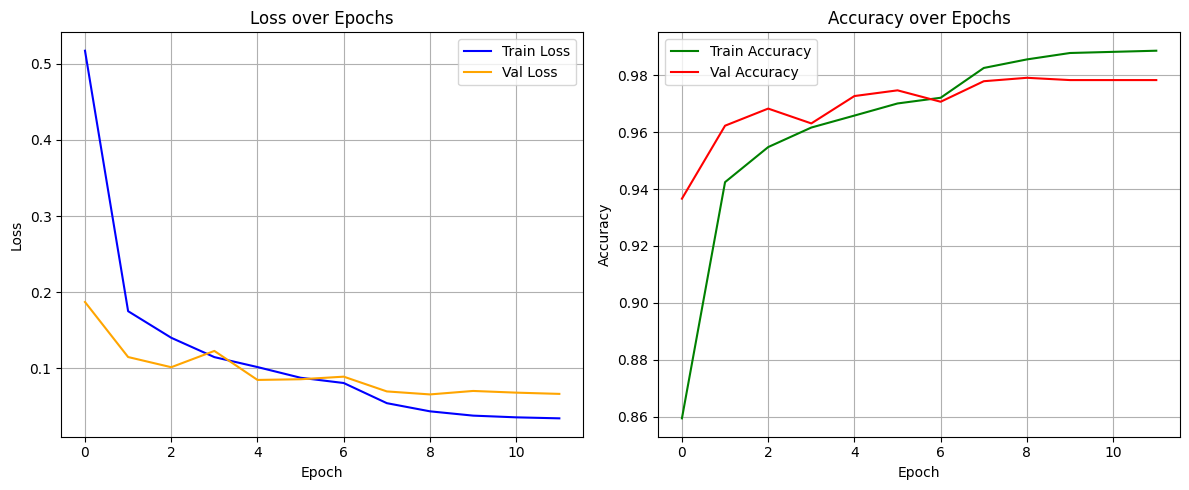

In [30]:
mplot.figure(figsize=(12, 5))

# Plotting Loss
mplot.subplot(1, 2, 1)
mplot.plot(history.history['loss'], label='Train Loss', color='blue')
mplot.plot(history.history['val_loss'], label='Val Loss', color='orange')
mplot.title('Loss over Epochs')
mplot.xlabel('Epoch')
mplot.ylabel('Loss')
mplot.legend()
mplot.grid(True)

# Plotting Accuracy
mplot.subplot(1, 2, 2)
mplot.plot(history.history['accuracy'], label='Train Accuracy', color='green')
mplot.plot(history.history['val_accuracy'], label='Val Accuracy', color='red')
mplot.title('Accuracy over Epochs')
mplot.xlabel('Epoch')
mplot.ylabel('Accuracy')
mplot.legend()
mplot.grid(True)

mplot.tight_layout()
mplot.show()


# Model Evaluation

In [56]:
xlm_roberta_model.evaluate(test_dataset)

156/156 [==============================] - 463s 3s/step - loss: 0.0771 - accuracy: 0.9775


[0.07708070427179337, 0.9775370955467224]

In [61]:
# Getting logits from model
predictions = xlm_roberta_model.predict(test_dataset)

156/156 [==============================] - 486s 3s/step


In [ ]:
# Converting logits to predicted class indices
ypred = numpy.argmax(predictions.logits, axis=1)

# True labels (already batched in test_dataset)
ytrue = numpy.concatenate([y for x, y in test_dataset], axis=0)

In [64]:
# Classificaiton report
print(classification_report(ytrue, ypred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       138
           1       1.00      1.00      1.00       138
           2       0.97      0.94      0.95       139
           3       0.93      0.96      0.95       138
           4       0.99      0.99      0.99       139
           5       0.99      0.98      0.98       138
           6       0.93      0.96      0.95       139
           7       1.00      1.00      1.00       139
           8       1.00      1.00      1.00       138
           9       0.94      0.96      0.95       139
          10       1.00      1.00      1.00       139
          11       1.00      1.00      1.00       138
          12       0.94      0.97      0.96       139
          13       1.00      0.99      1.00       138
          14       0.98      0.91      0.94       139
          15       0.96      0.96      0.96       138
          16       1.00      1.00      1.00       138
          17       0.98    

# Predicting with a sample

In [75]:
sample_text = 'Este es un ejemplo de oración.'

substitutions = [
    (r'<.*?>', ''),                           # HTML tags
    (r'http\S+|www\S+|ftp\S+', ''),           # URLs
    (r'@\w+', ''),                            # Mentions (e.g., @username)
    (r'[^\w\s.,!?¿¡:؛،。’‘“”\'"—\-()]+', ''),  # Non-linguistic symbols (preserve punctuations)
    (r'\s+', ' '),                            # Normalize whitespace
]

for pattern, repl in substitutions:
    sample_text = re.sub(pattern, repl, sample_text)

sample_text = sample_text.strip()

In [76]:
# Tokenizing
inputs = tokenizer(sample_text, return_tensors='tf', padding=True, truncation=True, max_length=100)

In [77]:
# Predict logits
outputs = xlm_roberta_model(inputs)
logits = outputs.logits
pred_class = tensorflow.argmax(logits, axis=1).numpy()[0]

In [78]:
predicted_language = LE.inverse_transform([pred_class])[0]

print(f'Sample Text: {sample_text}')
print(f'Predicted Language: {predicted_language}')

Sample Text: Este es un ejemplo de oración.
Predicted Language: Spanish


# The model outputs accurate results.